# Nome: Marcos Antonio Silva
# telefone: (91) 998388318
# Email: m.antonio22069@gmail.com
# linkedin: https://www.linkedin.com/in/marcos-silva-barros/

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.model_selection import train_test_split

In [151]:
df_treino = pd.read_csv('treino.csv')
df_teste = pd.read_csv('teste.csv')

In [152]:
df_treino.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Um modelo de credit scoring vai muito alem de treinar um modelo. Devemos entender o movimento que a esteira de crédito do cliente exige e definir exatamente o público alvo, alêm disso, devemos sempre observar como os níveis de risco podem impactar na inadimplencia final, por exemplo, um cliente classe "A" não possui o mesmo risco de um cliente classe "C" e isto deverá ser considerado no nosso modelo.

### Passo a Passo
    1 - Verificar e tratar NAs e valores anômalos
    2 - Verificar variáveis com alta correlação, evitando, assim, multicolinearidade dos dados
    3 - Devemos verificar como algumas variáveis se comportam diante da inadimplência e contruir alguns "Hard Filters"
    4 - Filtrar base de dados excuindo clientes barrados por "hard filters"
    5 - Tratar valores numéricos
    6 - Tratar valores categóricos
    7 - Treinar modelo v0
    8 - Abrir a classificação em quantis e verificar faixas de aprovação com sua respectiva inadimplência
    9 - Caso o resultado não seja satisfatório, podemos verificar a feature importance e reduzir variáveis que estejam "confundindo" o modelo, ou então, realizar feature engineering e construir novas variaveis.
    

In [153]:
def info(df):
    '''Funcao que retorna um resumo dos dados'''
    df_info = pd.DataFrame({'Colunas': df.columns, 'types': df.dtypes,
                          'NA #': df.isna().sum(),
                          'NA %': (df.isna().sum() / df.shape[0]) * 100})
    df_info = df_info.join(df.describe().T)
    
    return df_info

In [154]:
info(df_treino)

,Colunas,types,NA #,NA %,count,mean,std,min,25%,50%,75%,max
inadimplente,inadimplente,int64,0,0.000000,110000.0,0.066645,0.249408,0.0,0.000000,0.000000,0.000000,1.0
util_linhas_inseguras,util_linhas_inseguras,float64,0,0.000000,110000.0,5.929979,252.301965,0.0,0.030054,0.155936,0.562806,50708.0
idade,idade,int64,0,0.000000,110000.0,52.255636,14.768241,0.0,41.000000,52.000000,63.000000,109.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,0.000000,110000.0,0.424055,4.240780,0.0,0.000000,0.000000,0.000000,98.0
razao_debito,razao_debito,float64,0,0.000000,110000.0,354.823589,2074.140421,0.0,0.175016,0.366682,0.866874,329664.0
salario_mensal,salario_mensal,float64,21763,19.784545,88237.0,6637.411063,13383.950943,0.0,3400.000000,5400.000000,8225.000000,3008750.0
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,0.000000,110000.0,8.445573,5.139026,0.0,5.000000,8.000000,11.000000,58.0
numero_vezes_passou_90_dias,numero_vezes_passou_90_dias,int64,0,0.000000,110000.0,0.269955,4.217326,0.0,0.000000,0.000000,0.000000,98.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,0.000000,110000.0,1.019891,1.135989,0.0,0.000000,1.000000,2.000000,54.0
numero_de_vezes_que_passou_60_89_dias,numero_de_vezes_que_passou_60_89_dias,int64,0,0.000000,110000.0,0.243891,4.204137,0.0,0.000000,0.000000,0.000000,98.0


###    1 - Pelos dados acima, ja conseguimos verificar que duas colunas possuem valores faltas (NAs), uma dekas com quase 20% de valores faltantes. Precisamos verificar a possibilidade de dropar estes valores ou substitui-los por algo que faça sentido. A segunda coluna com valores faltantes possui cerca de 2,61% de NAs, como o percentual de dados é pequeno, podemos remover esses registros da base.

###    2 - Alem disso, podemos verificar alguns valores que provavelmente possuem valores discrepantes (outliers) que precisam ser tratados. Vamos verificar a distribuição numerica dessas variaveis e substituir os outliers por algum percentil que faça sentido.
    
###    3 - Podemos verificar que a base está desbalanceada, com cerca de 6,66% dos clientes inadimplentes. Será necessario realizar um balanceamento dos dados.

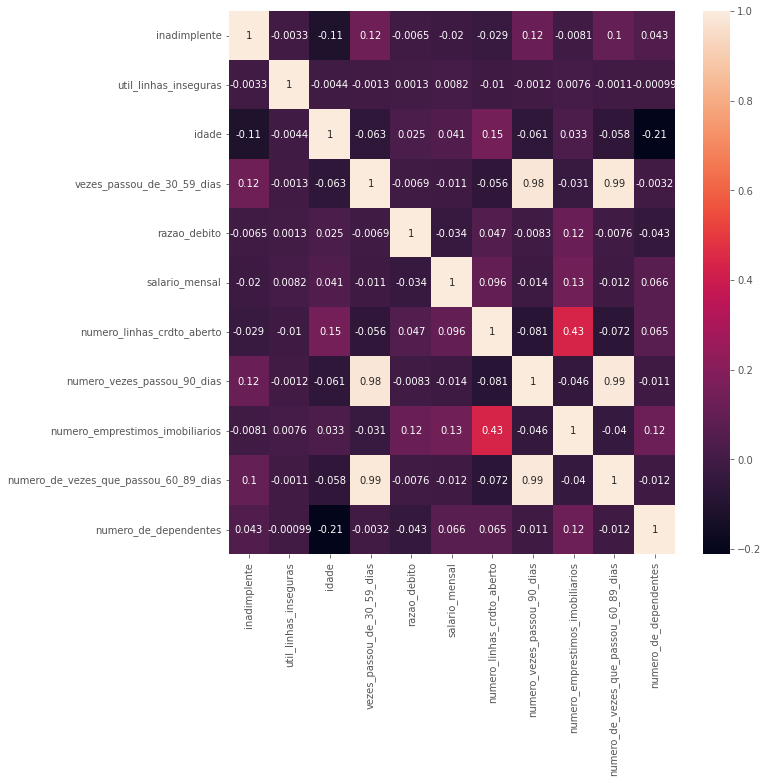

In [155]:
# Plotando uma matriz correlação 

fig, ax = plt.subplots(figsize=(10,10))
corrMatrix = df_treino.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

 - A maior parte das variáveis possuem baixa correlação, no entando, os numeros de passagens ao longo do tempo possuem alta correlação e seria interessante manter somente um, afim de evitar multicolinearidade.

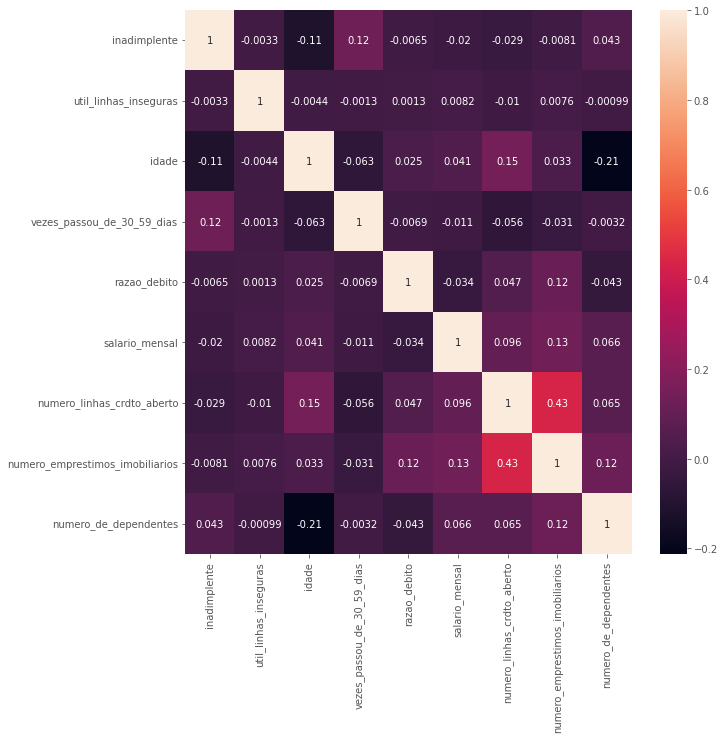

In [156]:
# Plotando uma matriz correlação sem as variáveis acima listadas

fig, ax = plt.subplots(figsize=(10,10))
colunas = ['numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias']
df_treino.drop(columns = colunas, inplace = True)
corrMatrix = df_treino.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Criaremos uma nova variavel com a finalidade de tentar descrever melhor a população

- salario/dependente

In [157]:
# Caso a pessoa não possua nenhum dependente, significa que a unica pessoa que gera custos é ela mesmo
df_treino['numero_de_dependentes'] = df_treino['numero_de_dependentes'] + 1

df_treino['numero_de_dependentes'].fillna(1, inplace=True)

# Para o caso de renda, decidimos dropar as variaveis NAs, visto que o montante de registros restantes ainda é suficiente
# para realizar a modelagem
df_treino.dropna(inplace=True)

# Razão entre a renda e o numero de dependentes
df_treino['salario_dependente'] = df_treino['salario_mensal']/df_treino['numero_de_dependentes']

In [158]:
info(df_treino)

,Colunas,types,NA #,NA %,count,mean,std,min,25%,50%,75%,max
inadimplente,inadimplente,int64,0,0.0,88237.0,0.068951,0.253372,0.0,0.000000,0.000000,0.000000,1.0
util_linhas_inseguras,util_linhas_inseguras,float64,0,0.0,88237.0,5.855376,260.699437,0.0,0.035312,0.178883,0.582609,50708.0
idade,idade,int64,0,0.0,88237.0,51.248320,14.413576,0.0,40.000000,51.000000,61.000000,103.0
vezes_passou_de_30_59_dias,vezes_passou_de_30_59_dias,int64,0,0.0,88237.0,0.387491,3.596258,0.0,0.000000,0.000000,0.000000,98.0
razao_debito,razao_debito,float64,0,0.0,88237.0,26.827167,389.682244,0.0,0.143494,0.296660,0.482688,61106.5
salario_mensal,salario_mensal,float64,0,0.0,88237.0,6637.411063,13383.950943,0.0,3400.000000,5400.000000,8225.000000,3008750.0
numero_linhas_crdto_aberto,numero_linhas_crdto_aberto,int64,0,0.0,88237.0,8.755352,5.165944,0.0,5.000000,8.000000,11.000000,58.0
numero_emprestimos_imobiliarios,numero_emprestimos_imobiliarios,int64,0,0.0,88237.0,1.055884,1.156483,0.0,0.000000,1.000000,2.000000,54.0
numero_de_dependentes,numero_de_dependentes,float64,0,0.0,88237.0,1.851910,1.147779,1.0,1.000000,1.000000,3.000000,21.0
salario_dependente,salario_dependente,float64,0,0.0,88237.0,4487.913832,6600.005573,0.0,1959.000000,3333.333333,5660.000000,752187.5


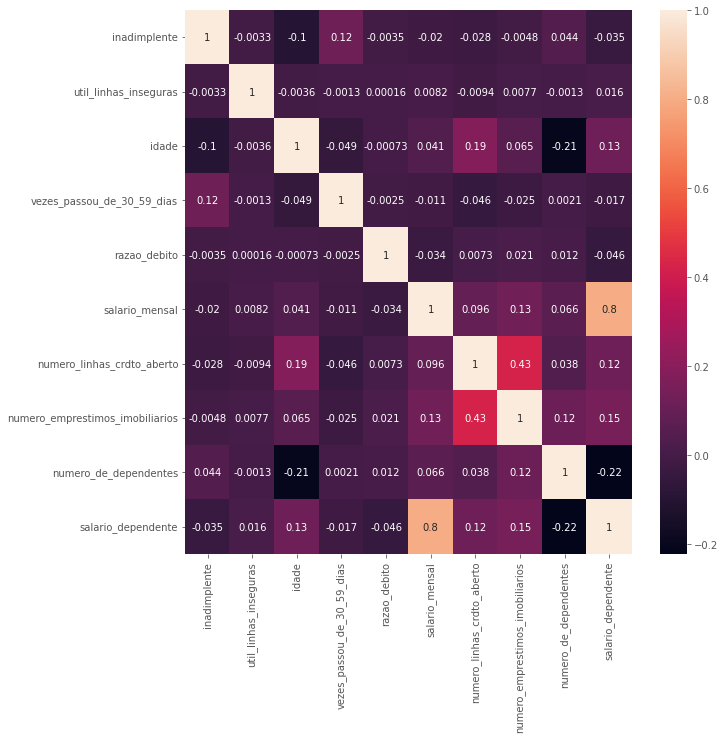

In [159]:
# Plotando uma matriz correlação 

fig, ax = plt.subplots(figsize=(10,10))
corrMatrix = df_treino.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### A nova variavel apresentar alta correlação, Vamos corta-la

In [160]:
df_treino.drop(columns = ['salario_dependente'], inplace = True)

In [161]:
# Balanceando os dados com base na classe de menor quantidade com o objetivo de vozualizar
# melhor as caracteristicas da população

g = df_treino.groupby('inadimplente')
df_treino_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [162]:
def substitute_data_quantile(data, valor_percentil):
    '''Substitui os valores superiores ao valor de referaencia pelo proprio valor de referencia'''
    return data if data < valor_percentil else valor_percentil

def plot_density(data, coluna, percentil = None):
    if percentil != None:
        
        valor_percentil = data[coluna].quantile(percentil)
        data[coluna] = data[coluna].apply(lambda x: substitute_data_quantile(x, valor_percentil))
        

    sns.displot(data, 
            x=coluna, 
            hue="inadimplente", 
            kind="kde", 
            height = 7, 
            multiple="stack", 
            alpha=.3, 
            linewidth=0, hue_order = [1,0])

def plot_hist(data, coluna, percentil = None):
    if percentil != None:
        
        valor_percentil = data[coluna].quantile(percentil)
        data[coluna] = data[coluna].apply(lambda x: substitute_data_quantile(x, valor_percentil))
    
    sns.displot(data, 
            x=coluna, 
            hue="inadimplente", 
            kind="hist", 
            height = 7, multiple="dodge", alpha=.3, linewidth=0, hue_order = [1,0], stat="percent")

In [163]:
var_discretas = ['idade', 'vezes_passou_de_30_59_dias', 
                 'numero_linhas_crdto_aberto', 'numero_emprestimos_imobiliarios', 
                 'numero_de_dependentes']

var_continuas = ['util_linhas_inseguras', 'razao_debito', 'salario_mensal']

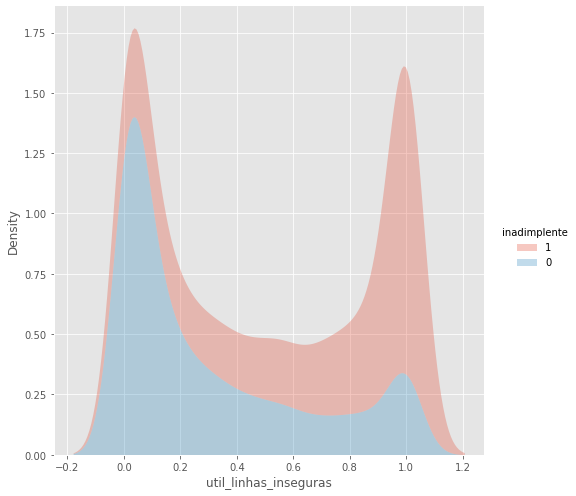

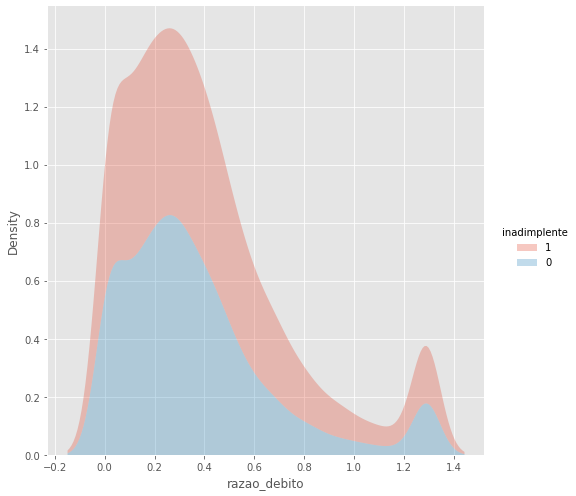

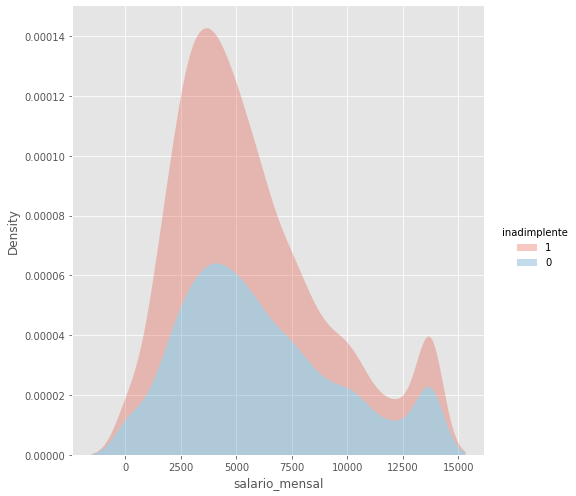

In [164]:
# Nesta etapa, vamos percorrer todas as variaveis plotando suas distribuições e tratando outliers, trazendo valores
# discrepantes para para o p95

for coluna in var_continuas:
    plot_density(df_treino_balanced, coluna, 0.95)

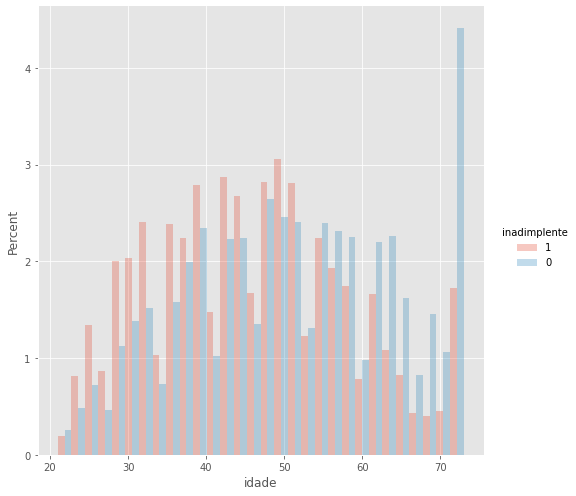

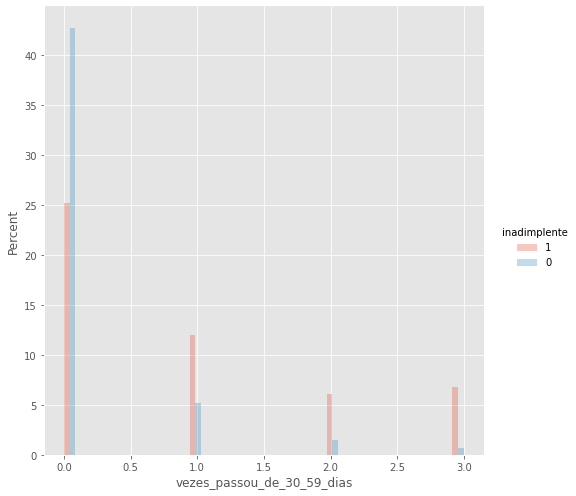

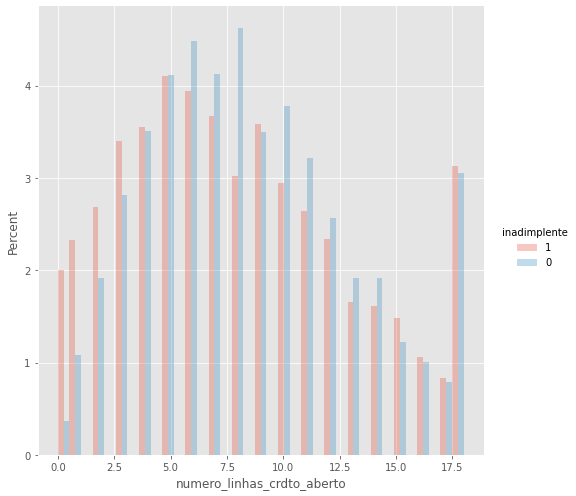

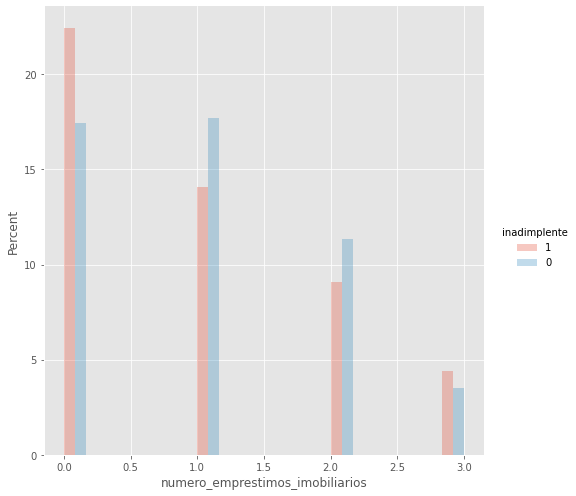

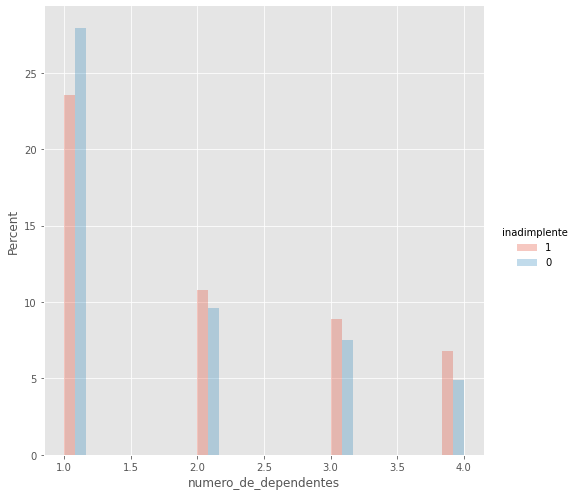

In [165]:
for coluna in var_discretas:
    plot_hist(df_treino_balanced, coluna, 0.95)

###    - Aqui temos alguns aspectos importantes que ja podemos utilizar nos nossos "Hard Filters":
    
###        1 - util_linhas_inseguras: Valores acima de 0.45 apresentam uma distribuição de inadimplentes muito maior que adimplentes
###        2 - vezes_passou_de_30_59_dias: Pessoas com pelo menos 1 passagem possuem muito mais chance de inadimplencia
###        3 - Salario_mensal: podemos verificar a viabilidade de cortar pessoas com renda zero ou muito baixas
###        4 - Pessoas mais velhas tendem a ser mais adimplentes
    
### Podemos utilizar essas informações para contruir alguns hard filter e logo de primeira reduzir drasticamente a nossa inadimplencia

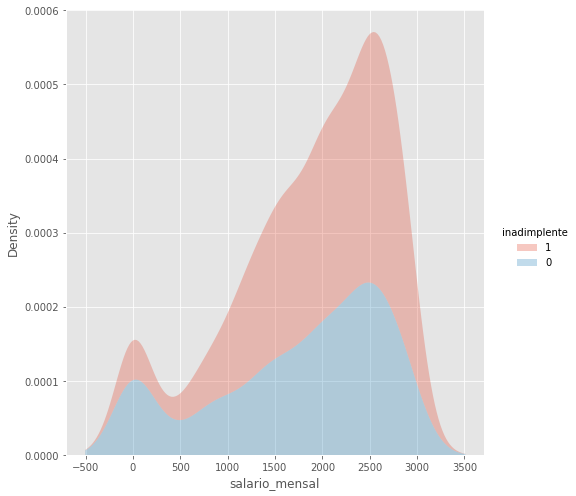

In [166]:
# Olhando para a coluna de renda

booleano = df_treino_balanced['salario_mensal'] < 3000

sns.displot(df_treino_balanced[booleano], 
            x='salario_mensal', 
            hue="inadimplente", 
            kind="kde", 
            height = 7, 
            multiple="stack", 
            alpha=.3, 
            linewidth=0, hue_order = [1,0])

# Como podemos observar, há renda zerada e ate mesmo negativa na distribuição, dessa forma, vamos remover pessoas com renda
# inferior a 1000 visando excluir clientes ruins ou erros na base, contudo, sem perder muita volumetria

In [167]:
# Primeiro "Hard filter": Vamos remover ou negar clientes cuja variavel util_linhas_inseguras seja maior que 0.45
# Segundo "Hard Filter": Vamos remover ou negar clientes cujo variavel vezes_passou_de_30_59_dias seja maior que 0
# Terceiro "Hard Filter": Vamos remover ou negar clientes cujo a variavel salario_mensal seja menor que 1000

def getHardFilter(data):
    data = data[data['util_linhas_inseguras'] < 0.45]
    data = data[data['vezes_passou_de_30_59_dias'] < 1]
    data = data[data['salario_mensal'] > 1000]
    
    return data

In [168]:
# Pegando o Total de clientes antes do hard filter, ou seja, o nosso through the door
TTD_df_treino = df_treino.shape[0]

df_treino = getHardFilter(df_treino)

# Somente com esses hardFilters, conseguimos reduzir nossa inadimplencia de 6.66% para 1.97%; uma redução de 70.42% do
# numero de inadimplentes !!

scoragem_df_treino = df_treino.shape[0]

df_treino.inadimplente.value_counts(normalize = True)

0    0.980241
1    0.019759
Name: inadimplente, dtype: float64

### Somente com esses hardFilters, conseguimos reduzir nossa inadimplencia de 6.66% para 1.97%; uma redução de 70.42% do numero de inadimplentes !!

In [169]:
# Podemos observar que a nova base filtrou cerca de 41.38% dos usuarios, "limpando" boa parte da base sem ao 
# menos fazer um modelo

(1 - scoragem_df_treino/TTD_df_treino)*100

41.38059997506714

### Apos os "Hard filters", a base apresentou-se muito desbalanceada e para corrigir isso **APENAS PARA A DATABASE DE TREINO**, vamos utilizar a função SMOTE para combinar metodos de under e over sampling

In [170]:
# Separando as variaveis do Target e balanceando
X = df_treino.iloc[:, 1:]
y = df_treino.iloc[:, 0]

# Separando nosso dataset em treino e teste, alem disso, vamos separar nosso tente em model_test e outOfSample_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [171]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Criando pipeline e estruturando balanceamento
over = SMOTE(sampling_strategy=0.15, random_state= 1234)

under = RandomUnderSampler(sampling_strategy=0.35, random_state= 4321)

steps = [('o', over), ('u', under)]

# estruturando pipeline e realizando modificações de balanceamento
pipeline = Pipeline(steps=steps)
X_train, y_train = pipeline.fit_resample(X_train, y_train)


In [172]:
# Construindo o modelo lightgbm e treinando-o
import lightgbm as lgb
clf = lgb.LGBMClassifier()


In [173]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Definindo  evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Criando estimadores para testar o modelo com diferentes configurações

boosting_type = ['gbdt', 'dart']

#max_depth = [int(x) for x in np.linspace(-1, 30, num = 10)]

learning_rate = [round(x, 3) for x in np.linspace(0.2, 0.3, num = 5)]

n_estimators = [150, 200, 250]


search_grid = {'boosting_type': boosting_type,

               #'max_depth': max_depth,

               'learning_rate': learning_rate,

               'n_estimators': n_estimators}

In [174]:
clf_search = GridSearchCV(estimator = clf, 
                          param_grid = search_grid, 
                          n_jobs = -1,
                          cv = cv,
                          verbose=3,
                          scoring='roc_auc')

In [175]:
import warnings
warnings.filterwarnings("ignore")

clf_search.fit(X_train, y_train)

Fitting 15 folds for each of 30 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  8.9min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_g

In [183]:
parameters = clf_search.cv_results_

results = pd.DataFrame(parameters).sort_values('rank_test_score')

In [184]:
parameters = clf_search.best_params_

#parameters = results[results['rank_test_score'] == 2].loc[53,'params']

parameters

{'boosting_type': 'dart', 'learning_rate': 0.2, 'n_estimators': 150}

In [185]:
# Construindo o modelo com base nos melhores parametros estimados acima

model = lgb.LGBMClassifier(n_estimators = parameters['n_estimators'],
                           #max_depth = parameters['max_depth'],
                           learning_rate = parameters['learning_rate'],
                           boosting_type = parameters['boosting_type'])

model.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [179]:
# Calculando as previsões do nosso dataframe de teste ( Probabilidade de NÃO INADIMPLENCIA)
X_test['y_preds.0'] = X_test.apply(lambda x: 1000*model.predict_proba([x])[0][0], axis = 1)

In [180]:
X_test = pd.concat([X_test, y_test], axis=1, join="inner")

In [181]:
def getAnaliseDeKS(data, n_quantis = 10):
    cuts = n_quantis
    data['quantile'] = pd.qcut(data['y_preds.0'], q = cuts, labels=range(1, cuts+1))

    g = data.groupby('quantile')

    data_group_min_max = g['y_preds.0'].agg(ScoreMin = 'min', ScoreMax = 'max')
    
    data_group_mau_count = g['inadimplente'].agg(Mau = 'sum', count = 'count')
    
    data_group = pd.concat([data_group_min_max, data_group_mau_count], axis=1, join="inner")
    
    data_group['Bom'] = data_group['count'] - data_group['Mau']
    
    total_bom = data[data['inadimplente'] == 0].inadimplente.value_counts()[0]
    total_mau = data[data['inadimplente'] == 1].inadimplente.value_counts()[1]
    
    data_group['pct_bom'] = data_group['Bom']*100/total_bom
    data_group['pct_mau'] = data_group['Mau']*100/total_mau
    
    data_group['cum_Bom'] = data_group['pct_bom'].cumsum()
    data_group['cum_Mau'] = data_group['pct_mau'].cumsum()
    
    data_group['KS'] = data_group['cum_Mau'] - data_group['cum_Bom']
    
    data_group['pct_inadimplencia'] = data_group['Mau']*100/data_group['count']
    
    return data_group

In [194]:
AnalisePorFaixa = getAnaliseDeKS(X_test, 10)
AnalisePorFaixa

,ScoreMin,ScoreMax,Mau,count,Bom,pct_bom,pct_mau,cum_Bom,cum_Mau,KS,pct_inadimplencia
quantile,,,,,,,,,,,
1,132.769662,870.432821,72,1552,1480,9.732360,23.151125,9.732360,23.151125,1.341877e+01,4.639175
2,870.433159,904.319902,39,1552,1513,9.949365,12.540193,19.681726,35.691318,1.600959e+01,2.512887
3,904.338472,924.230629,42,1552,1510,9.929638,13.504823,29.611363,49.196141,1.958478e+01,2.706186
4,924.236119,939.078223,36,1551,1515,9.962517,11.575563,39.573880,60.771704,2.119782e+01,2.321083
5,939.083700,950.794756,29,1552,1523,10.015125,9.324759,49.589005,70.096463,2.050746e+01,1.868557
6,950.799968,960.193016,31,1552,1521,10.001973,9.967846,59.590978,80.064309,2.047333e+01,1.997423
7,960.193386,968.369687,20,1551,1531,10.067732,6.430868,69.658710,86.495177,1.683647e+01,1.289491
8,968.383038,976.429732,18,1552,1534,10.087460,5.787781,79.746170,92.282958,1.253679e+01,1.159794
9,976.433521,983.531865,15,1552,1537,10.107187,4.823151,89.853357,97.106109,7.252752e+00,0.966495


### Aqui podemos verificar como se distribui a faixa de risco e o KS, selecionando as 4 primeiros faixas, ou seja, aprovando somente os clientes cujo o Score seja maior que 754.350988	 e atribuindo as letras A, B, C, D e E, podemos observar que as inadimplencia encontrar-se-á entre 0.57% na melhor faixa e 1.99% na pior faixa. Alem disso, cabe destacar que selecionando estas faixas, teremos um % de aprovação de cerca de 50% daqueles que passaram pelos "Hard Filters" ou 8.79% do through the door.


In [187]:
# Calculando as previsões do nosso dataframe de treino + teste ( Probabilidade de NÃO INADIMPLENCIA)
df_treino['y_preds.0'] = df_treino.apply(lambda x: 1000*model.predict_proba([x[1:]])[0][0], axis = 1)

### Analisando os dados de treino + teste, podemos observar que nas mesmas faixas as caracteristicas de inadimplencia se mantem. Como nosso teste é out-of-sample e não está balanceado, espera-se que haja uma diferença entre as escoragens, contudo, o padrão deve-se manter

In [188]:
getAnaliseDeKS(df_treino, 10)

,ScoreMin,ScoreMax,Mau,count,Bom,pct_bom,pct_mau,cum_Bom,cum_Mau,KS,pct_inadimplencia
quantile,,,,,,,,,,,
1,110.933702,870.447891,618,5173,4555,8.983867,60.469667,8.983867,60.469667,5.148580e+01,11.946646
2,870.459122,904.744054,114,5172,5058,9.975938,11.154599,18.959804,71.624266,5.266446e+01,2.204176
3,904.765198,924.632361,76,5172,5096,10.050886,7.436399,29.010690,79.060665,5.004998e+01,1.469451
4,924.636708,939.408277,64,5173,5109,10.076526,6.262231,39.087215,85.322896,4.623568e+01,1.237193
5,939.414289,950.949938,41,5172,5131,10.119916,4.011742,49.207132,89.334638,4.012751e+01,0.792730
6,950.951838,960.225577,36,5172,5136,10.129778,3.522505,59.336910,92.857143,3.352023e+01,0.696056
7,960.225917,968.580179,26,5173,5147,10.151473,2.544031,69.488383,95.401174,2.591279e+01,0.502610
8,968.581449,976.446481,21,5172,5151,10.159363,2.054795,79.647746,97.455969,1.780822e+01,0.406032
9,976.446831,983.628248,18,5172,5154,10.165279,1.761252,89.813025,99.217221,9.404196e+00,0.348028


### Podemos observar que o percentual de inadimplencia e o KS por faixa se mantem muito proximo dos dados de teste, logo, o modelo conseguiu se adaptar muito bem ao que foi proposto

In [196]:
# Vamos filtrar os aprovados e calcular a inadimplencia media

aprovados = AnalisePorFaixa[AnalisePorFaixa['ScoreMin'] >= 950.79996]

sum(aprovados['pct_inadimplencia'] * aprovados['count'])/sum(aprovados['count'])

1.1986080680500064

### A inadimplencia media será a media ponderada das faixas de risco, dessa forma, conseguimos reduzir a inadimplencia de 6.66% inicialmente para cerca de 1.19%, uma redução de 82.13%

In [199]:
def getScore(Score_numerico):
    '''Funcao que retorna a letra do score conforme a probabilidade de inadimplencia'''
    if Score_numerico >= 983.53592:
        return 'A'
    elif Score_numerico >= 976.43352:
        return 'B'
    elif Score_numerico >= 968.38303:
        return 'C'
    elif Score_numerico >= 960.19338	:
        return 'D'
    elif Score_numerico >= 950.79996	:
        return 'E'
    else:
        return 'F'

In [201]:
X_test['y_preds.0'].apply(lambda x: getScore(x)).value_counts().sort_index()

A    1552
B    1552
C    1552
D    1551
E    1552
F    7759
Name: y_preds.0, dtype: int64

## Agora, vamos submeter o dataset de test para verificação

In [210]:
df_teste = pd.read_csv('teste.csv')

# Primeiro: Passar a base de dados hard Filter que ja remove boa parte da "sujeira"

shape_inicial = df_teste.shape[0]

df_teste = getHardFilter(df_teste)

# Caso a pessoa não possua nenhum dependente, significa que a unica pessoa que gera custos é ela mesmo
df_teste['numero_de_dependentes'] = df_teste['numero_de_dependentes'] + 1

df_teste['numero_de_dependentes'].fillna(1, inplace=True)

# Para o caso de renda, decidimos dropar as variaveis NAs, visto que o montante de registros restantes ainda é suficiente
# para realizar a Scoragem
df_teste.dropna(inplace=True)

# Dropando as variaveis não importantes para o modelo
colunas = ['numero_vezes_passou_90_dias', 'numero_de_vezes_que_passou_60_89_dias']
df_teste.drop(columns = colunas, inplace = True)

In [211]:
df_teste['y_preds.0'] = df_teste.apply(lambda x: 1000*model.predict_proba([x])[0][0], axis = 1)

In [212]:
df_teste['Score'] = df_teste['y_preds.0'].apply(lambda x: getScore(x))

### Contagem por Score de cada um dos clientes Scorados

In [213]:
df_teste.Score.value_counts().sort_index()

A    1924
B    1867
C    2015
D    1818
E    1825
F    9357
Name: Score, dtype: int64

### Podemos observar que a taxa de aprovação subiu para 23.62% em relação ao TTD nesta base, mostrando que possivelmente houve um deslocamento das variaveis, ou seja, um shift e a população cujo modelo foi treinado possivelmente não apresenta totalmente as mesmas caracteristicas das que estão sendo testadas. 

In [215]:
sum(df_teste[df_teste['Score'] != 'F'].Score.value_counts()) * 100/shape_inicial

23.6225

### Contudo, quando olhamos somente para a população que chegou ao modelo para ser escorada, nossa aprovação está de acordo com o que foi previsto inicialmente

In [217]:
sum(df_teste[df_teste['Score'] != 'F'].Score.value_counts()) * 100 / df_teste.shape[0]

50.244602786344785

### Alem disso, podemos observar que a nossa inadimplencia esperada está de acordo com o que foi previamente estudado

In [220]:
somaProduto = df_teste[df_teste['Score'] != 'F'].Score.value_counts().sort_index() * list(aprovados.pct_inadimplencia)

In [222]:
sum(somaProduto) / df_teste[df_teste['Score'] != 'F'].Score.value_counts().sum()

1.2067842420900494

# Dessa forma, podemos concluir que o modelo proposto, apesar de simples, é muito eficiente quando combinado com uma otima politica de credito (esteira de credito), reduzindo drasticamente o % de inadimplencia dos usuarios. Alem disso, o modelo mostrou-se estavel para a previsão de novos clientes para a base.

# Desde ja agradeço pela oportunidade e coloco-me a disposição para eventuais duvidas.

# Atenciosamente

